In [22]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : Symmetric Convolution


TensorShape([50, 50])

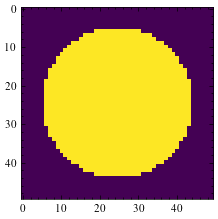

In [23]:
'''img = np.zeros((45, 45))
center_coordinates = (img.shape[0]//2, img.shape[1]//2) 
img = cv2.circle(img, center_coordinates, 20, (255,255,255), -1) 
plt.imshow(img)'''


N = 50
#img =  tf.image.rot90(tf.random.uniform(shape=(50,50,1), minval=0., maxval=1.), k=1) #
#img = tf.image.pad_to_bounding_box(img, 25//2,25//2,N+25, N+25)[...,0]

img =  tf.expand_dims(cv2.imread('input4.png', 0)/255. , axis=-1)
H, W, C = img.shape  # Get image dimensions
offset_height = (H - N) // 2
offset_width = (W - N) // 2
img = tf.image.crop_to_bounding_box(img, offset_height, offset_width, N, N)[...,0]
plt.imshow(img)
img.shape


(50, 50)


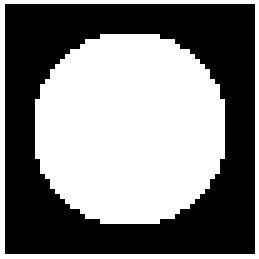

In [24]:
#var = 2/(128*9)

fig,ax = plt.subplots(1)

ax.imshow(img, cmap='gray')

#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("input.png",bbox_inches='tight',   pad_inches = 0)


Original shape: (500, 500)


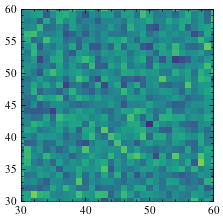

In [25]:
img = np.random.normal(loc=0.0, scale=1.0, size=(500, 500))
print("Original shape:", img.shape)

# Pad with 10 pixels of zeros on all sides
img = np.pad(img, pad_width=((10, 10), (10, 10)), mode='constant', constant_values=0)

fig, ax = plt.subplots()
ax.imshow(img)
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()

In [26]:
'''img  = np.zeros((7, 7)) # np.random.uniform(low=0, high=1, size=(50,50,10))
img[3, 3 ]=1.

plt.imshow(img)'''

'img  = np.zeros((7, 7)) # np.random.uniform(low=0, high=1, size=(50,50,10))\nimg[3, 3 ]=1.\n\nplt.imshow(img)'

In [27]:
w = np.zeros((3,3,1,1))


t1 = np.zeros((3,3))
t2 = np.zeros((3,3))

'''t1[1, 2] = 1.
t2[2, 1] = 1.'''
t1[1,0] = 1.
t2[0, 1] = 1.


w1 = fft.idctn(t1, norm='ortho')
#w1 /= np.sum(np.abs(w1))

w2 = fft.idctn(t2, norm='ortho')
#w2 /= np.sum(np.abs(w2))

w[:,:,0,0] = (np.cos(-np.pi))*w1 + ( np.sin(-np.pi))*w2
print(tf.math.reduce_euclidean_norm(w))
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))


print(tf.math.reduce_euclidean_norm(w))
x = img

print("IMG", (tf.math.reduce_euclidean_norm(img)))



directory = f"figures/malus_high_order"
if not os.path.exists(directory):
	os.makedirs(directory)


response_mag = []
init_mag = tf.math.reduce_euclidean_norm(x).numpy()



i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 

print("I0,", tf.math.reduce_euclidean_norm(i0))


i1 = tf.nn.relu(tf.nn.conv2d(i0, w , strides=(1,1), padding='SAME') )

print("I1,", tf.math.reduce_euclidean_norm(i1))



init_mag = tf.math.reduce_euclidean_norm(i1).numpy()

angles = np.linspace(-np.pi, np.pi, 100)
for i in range(100):
	#fig, ax = plt.subplots()
	
	
	w[:,:,0,0] = (np.cos(angles[i]))*w1 + ( np.sin(angles[i]))*w2
	w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))
		
	x_out = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
								padding='SAME') )

	response_mag.append(tf.math.reduce_euclidean_norm(x_out).numpy()/init_mag)
	print(tf.math.reduce_euclidean_norm(x_out).numpy(), response_mag[-1])

tf.Tensor(0.9999999999999999, shape=(), dtype=float64)
tf.Tensor(1.0, shape=(), dtype=float64)
IMG tf.Tensor(500.27115561494026, shape=(), dtype=float64)
I0, tf.Tensor(500.27115, shape=(), dtype=float32)
I1, tf.Tensor(351.75595, shape=(), dtype=float32)
334.02737 0.9495998
333.5059 0.94811726
331.95166 0.94369876
329.37518 0.9363742
325.7942 0.92619383
321.23395 0.9132296
315.7275 0.89757544
309.31628 0.8793491
302.0493 0.8586899
293.98456 0.83576286
285.19022 0.8107616
275.74512 0.78391033
265.74014 0.75546736
255.28003 0.72573054
244.48503 0.69504166
233.4963 0.663802
222.47649 0.632474
211.61345 0.60159165
201.11987 0.5717597
191.23845 0.543668
182.24152 0.5180908
174.42276 0.495863
168.08429 0.4778435
163.50262 0.46481836
160.89575 0.45740733
160.39732 0.45599037
162.03062 0.46063364
165.70856 0.47108957
171.25284 0.48685127
178.40744 0.50719094
186.87689 0.5312686
196.36493 0.55824196
206.58922 0.5873084
217.29199 0.6177351
228.24646 0.6488773
239.25545 0.6801745
250.14586 0.71113

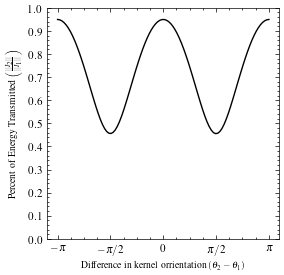

In [28]:
fig, ax= plt.subplots(1,1, figsize=(3,3))

ax.plot(angles,response_mag)

ticks = np.arange(-np.pi, 1.5*np.pi, np.pi/2)
labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels);
ax.set_yticks(ticks=np.arange(0,1.1, 0.1));

ax.set_ylabel(r"Percent of Energy Transmitted $\left( \frac{||I_{2}||}{||I_{1}||} \right)$", fontsize=7)
ax.set_xlabel(r"Difference in kernel orrientation $(\theta_2 - \theta_1)$", fontsize=7)

plt.savefig('malus2_high_order.pdf', dpi=600)
plt.show()


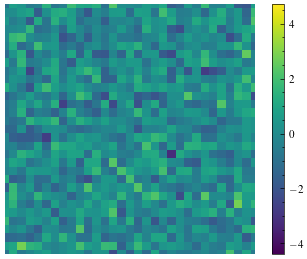

In [29]:
i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 

fig, ax= plt.subplots(1,1)


im =ax.imshow(i0[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i0_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)


tf.Tensor(500.27115, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=351.75595>

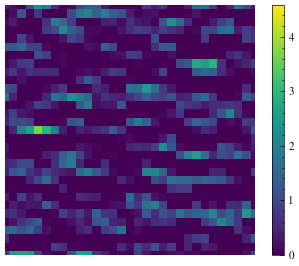

In [30]:
angle = -np.pi

w = np.zeros((3,3,1,1))

w[:,:,0,0] = (np.cos(angle))*w1 + ( np.sin(angle))*w2
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))


i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 

print((tf.math.reduce_euclidean_norm(i0)))

i1_x = tf.nn.relu( tf.nn.conv2d(i0, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i1[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');




ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i1_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)
tf.math.reduce_euclidean_norm(i1)



<tf.Tensor: shape=(), dtype=float32, numpy=334.02737>

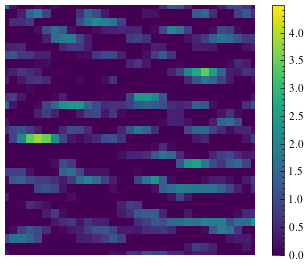

In [31]:
angle = -np.pi

w[:,:,0,0] = (np.cos(angle))*w1 + ( np.sin(angle))*w2
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))




i2_x = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i2_x[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)


fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i2_y_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)
tf.math.reduce_euclidean_norm(i2_x)

<tf.Tensor: shape=(), dtype=float32, numpy=160.12>

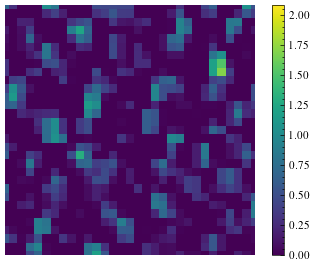

In [32]:
angle = np.pi/2

w[:,:,0,0] = (np.cos(angle))*w1 + ( np.sin(angle))*w2
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))




i2_y = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i2_y[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)


fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
#plt.savefig("i2_y_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)
tf.math.reduce_euclidean_norm(i2_y)

In [33]:
i0.shape

TensorShape([1, 520, 520, 1])

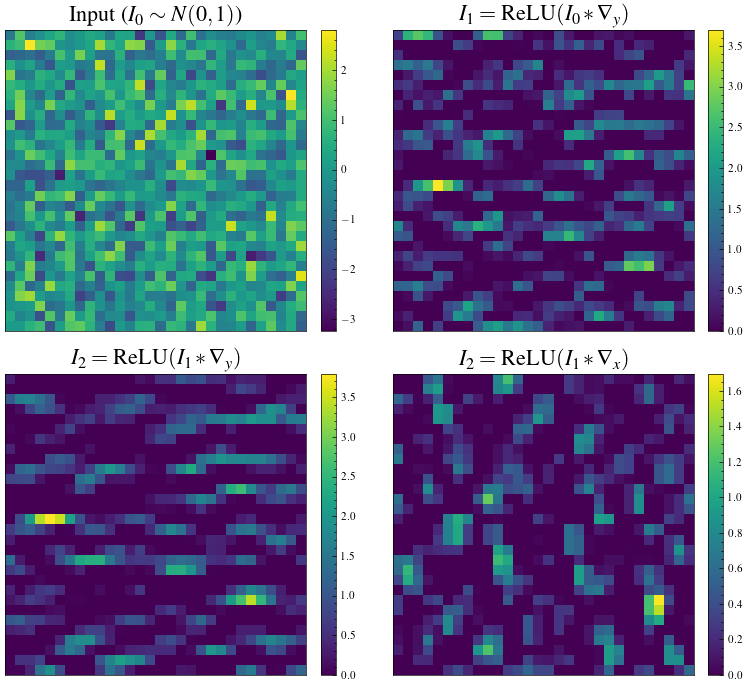

In [83]:
fig, axs = plt.subplots(2, 2, figsize=(8, 7))
title_fontsize = 16  # Adjust as needed

# Top-left
im0 = axs[0, 0].imshow(i0[0, 30:60, 30:60, 0].numpy(), cmap='viridis')
axs[0, 0].set_title(r'Input ($I_0 \sim N(0, 1)$)', fontsize=title_fontsize)
fig.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)
#ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

#fig.colorbar(im, orientation='vertical');


# Top-right
im1 = axs[0, 1].imshow(i1_x[0, 30:60, 30:60, 0].numpy(), cmap='viridis')
axs[0, 1].set_title(r'$I_1 = \mathrm{ReLU}(I_0 * \nabla_y)$', fontsize=title_fontsize)
fig.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

# Bottom-left
im2 = axs[1, 0].imshow(i2_x[0, 30:60, 30:60, 0].numpy(), cmap='viridis')
axs[1, 0].set_title(r'$I_2 = \mathrm{ReLU}(I_1 * \nabla_y)$', fontsize=title_fontsize)
fig.colorbar(im2, ax=axs[1, 0], fraction=0.046, pad=0.04)

# Bottom-right
im3 = axs[1, 1].imshow(i2_y[0, 30:60, 30:60, 0].numpy(), cmap='viridis')
axs[1, 1].set_title(r'$I_2 = \mathrm{ReLU}(I_1 * \nabla_x)$', fontsize=title_fontsize)
fig.colorbar(im3, ax=axs[1, 1], fraction=0.046, pad=0.04)

# Optional: tighten layout and remove axis ticks
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig("malus_gradient_random.pdf", dpi=600)

plt.show()




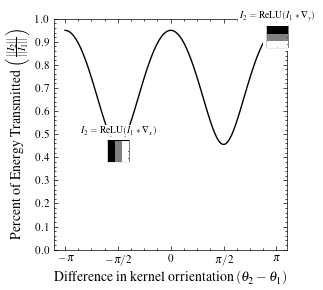

In [119]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea, VPacker
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def render_patch_with_border(patch, border_color='black', border_width=1, zoom=1.0):
	"""
	Renders a patch using imshow-style with a border and returns it as an OffsetImage.
	"""
	# Create a tiny figure to render the patch using imshow
	fig, ax = plt.subplots(figsize=(1, 1), dpi=100)
	canvas = FigureCanvas(fig)

	ax.imshow(patch, cmap='gray', interpolation='none')
	ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


	for spine in ax.spines.values():
		spine.set_visible(True)
		spine.set_linewidth(1)
		spine.set_color('black')

	# Make sure spines are drawn on top of the image
	ax.set_frame_on(True)
	# Add rectangle border
	'''h, w = patch.shape
	ax.add_patch(plt.Rectangle(
		(-0.5, -0.5), w, h,
		edgecolor=border_color,
		facecolor='none',
		linewidth=border_width
	))'''

	# Render to array
	canvas.draw()
	img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
	img = img.reshape(canvas.get_width_height()[::-1] + (3,))

	plt.close(fig)
	return OffsetImage(img, zoom=zoom)

# Function to place image on the curve

def add_patch_with_label(ax, x, y, patch, label):
	# Create rendered image with border
	imagebox = render_patch_with_border(patch, border_color='black', border_width=2, zoom=0.2)

	# Create label
	textbox = TextArea(label, textprops={
		'fontsize': 7,
		'ha': 'center',
		'va': 'center',
		'bbox': dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
	})

	# Stack vertically
	vpack = VPacker(children=[textbox, imagebox], align="center", pad=0, sep=3)
	ab = AnnotationBbox(vpack, (x, y), frameon=False, box_alignment=(0.5, 0.5))

	ax.add_artist(ab)


fig, ax= plt.subplots(1,1, figsize=(3,3))

ax.plot(angles,response_mag)

ticks = np.arange(-np.pi, 1.5*np.pi, np.pi/2)
labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels);
ax.set_yticks(ticks=np.arange(0,1.1, 0.1));

ax.set_ylabel(r"Percent of Energy Transmitted $\left( \frac{||I_{2}||}{||I_{1}||} \right)$", fontsize=10)
ax.set_xlabel(r"Difference in kernel orrientation $(\theta_2 - \theta_1)$", fontsize=10)

# Locations along curve
x1, y1 = -np.pi/2, response_mag[len(response_mag)//4]  # for dy
x2, y2 = np.pi, response_mag[-1]     # for dx
w[:,:,0,0] = (np.cos(np.pi))*w1 + ( np.sin(np.pi))*w2
dx_kernel = w[:,:,0,0]
dy_kernel = dx_kernel.T

add_patch_with_label(ax, x1, y1, dy_kernel, r'$I_2 = \mathrm{ReLU}(I_1 * \nabla_x)$')
add_patch_with_label(ax, x2, y2, dx_kernel, r'$I_2 = \mathrm{ReLU}(I_1 * \nabla_y)$')


plt.savefig('malus_curve_random.pdf', dpi=600)
plt.show()


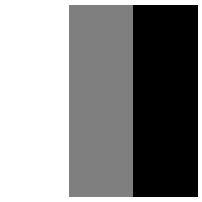

In [81]:
w[:,:,0,0] = (np.cos(np.pi/2))*w1 + ( np.sin(np.pi/2))*w2





p = plt.imshow(w[:,:,0,0], cmap='gray')
plt.axis('off')
p


array([[[[ 1.36082763e-01]],

        [[-1.85037171e-17]],

        [[-1.36082763e-01]]],


       [[[ 1.36082763e-01]],

        [[-1.85037171e-17]],

        [[-1.36082763e-01]]],


       [[[ 1.36082763e-01]],

        [[-1.85037171e-17]],

        [[-1.36082763e-01]]]])

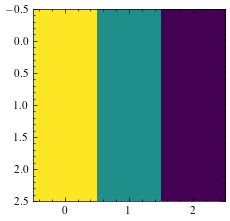

In [36]:
a = np.zeros((3,3))
a[0, 1] =1
a = np.reshape(fft.idctn(a, norm='ortho'), (3,3,1,1))

b = np.zeros((3,3))
b[0, 0] =1
b = np.reshape(fft.idctn(b, norm='ortho'), (3,3,1,1))

dct_basis = a*b

plt.imshow(dct_basis[..., 0,0])
dct_basis